In [37]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: rich_clust
python version: 3.9.12


In [38]:
import os
from pathlib import Path
# import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import numpy as np
import sklearn.manifold
import sklearn.cluster
import seaborn as sns
import pandas as pd
import sparse
import cv2
import natsort

import torch
# from kymatio.torch import Scattering2D

import gc
from tqdm.notebook import tqdm
import copy
import time
import random
import functools
import multiprocessing as mp


In [39]:
dir_github = Path(r'/media/rich/Home_Linux_partition/github_repos/').resolve()

import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from ROICaT.tracking import visualization, helpers


In [18]:
results = helpers.simple_load(r'/media/rich/bigSSD/analysis_data/ROI_tracking/Valerio/4th_email/results_localRuns/20220926/rbp6_3.plane0.ROICaT.results.pkl')
# results = helpers.simple_load(r'/home/rich/Desktop/NY044.rClust.pkl')

In [19]:
FOVs_colored = visualization.compute_colored_FOV(
    spatialFootprints=results['ROIs']['ROIs_aligned'], 
    FOV_height=results['ROIs']['frame_height'], 
    FOV_width=results['ROIs']['frame_width'], 
    preds=results['UCIDs'], 
)

<IPython.core.display.Javascript object>


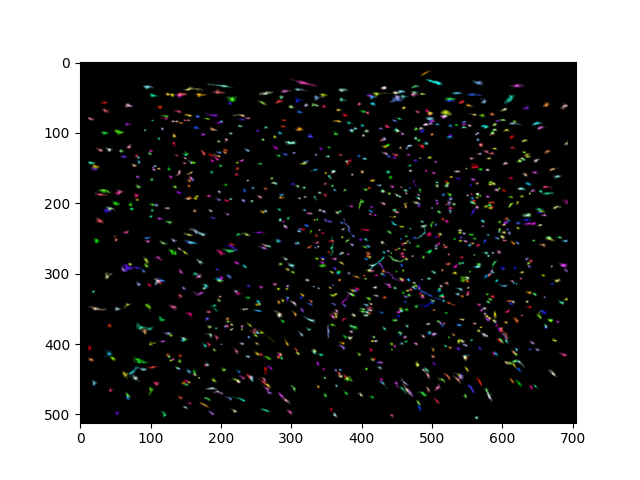

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [20]:
%matplotlib notebook

visualization.display_toggle_image_stack(FOVs_colored)

/tmp/ipykernel_47843/2771147402.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(40,1))


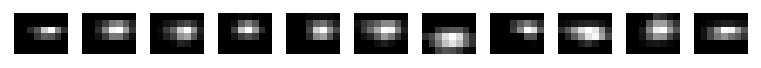

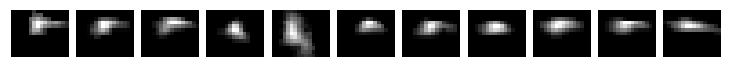

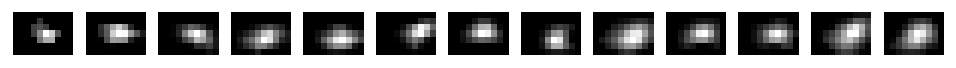

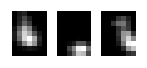

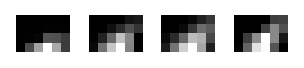

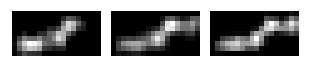

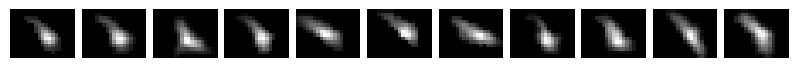

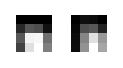

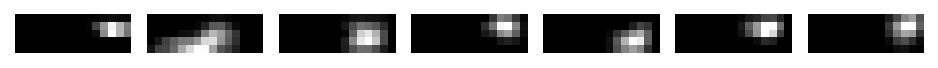

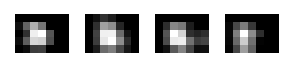

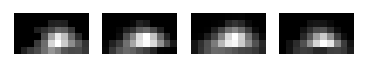

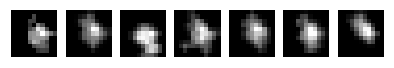

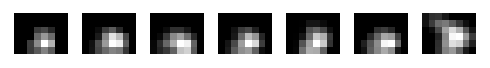

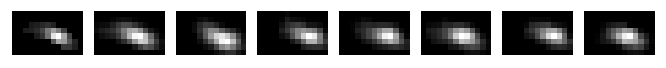

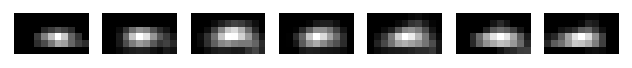

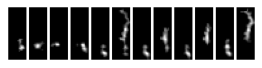

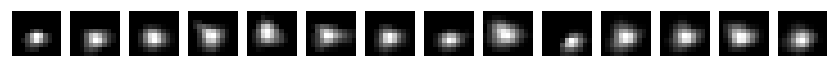

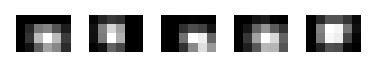

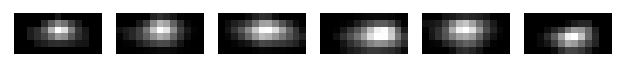

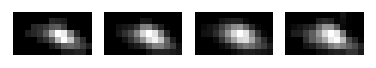

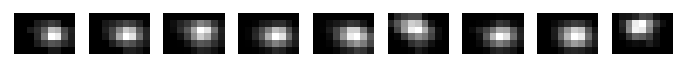

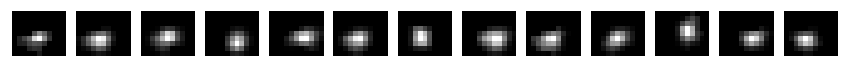

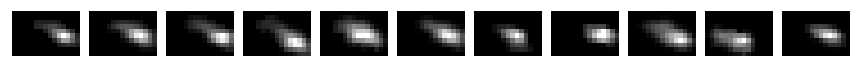

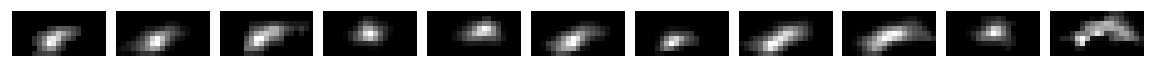

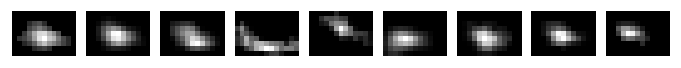

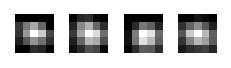

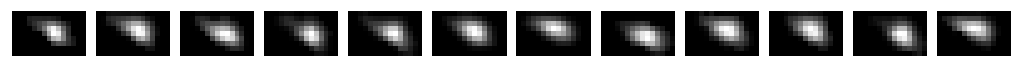

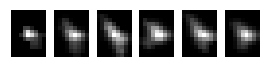

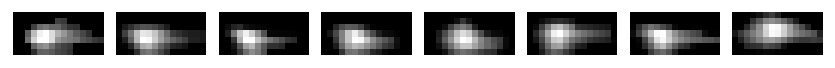

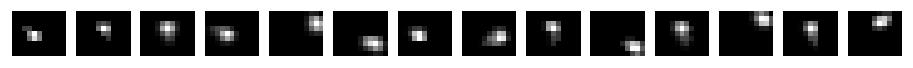

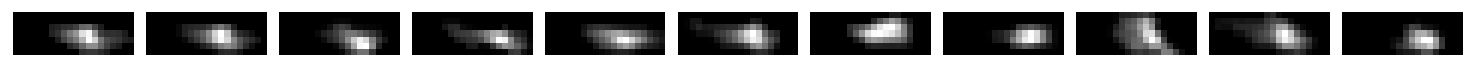

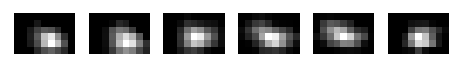

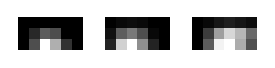

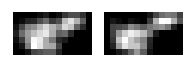

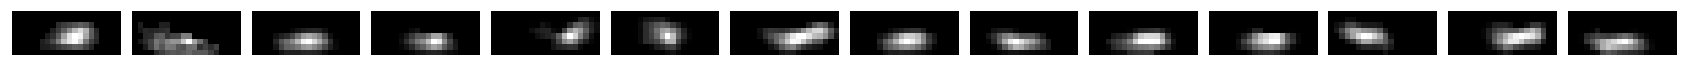

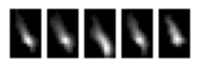

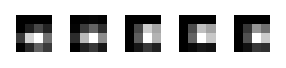

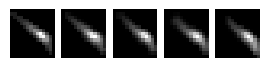

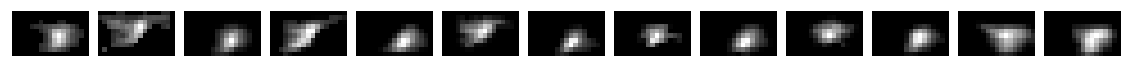

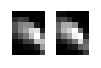

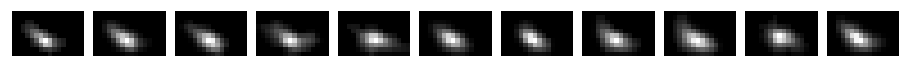

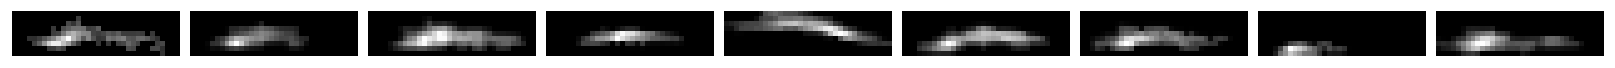

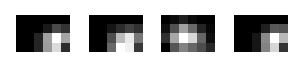

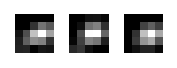

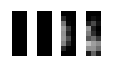

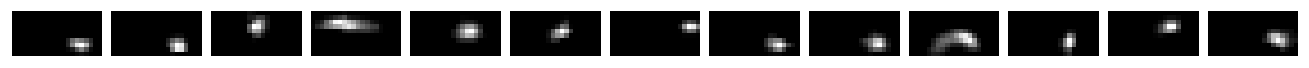

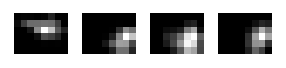

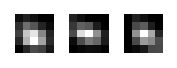

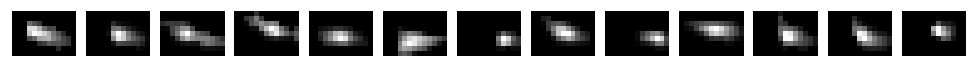

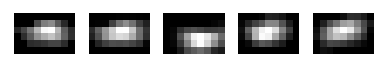

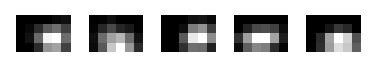

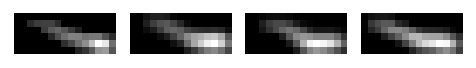

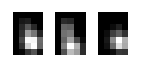

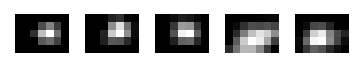

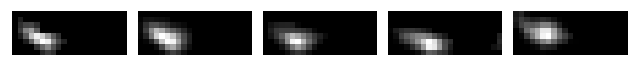

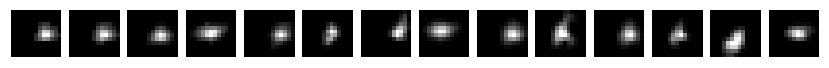

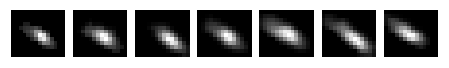

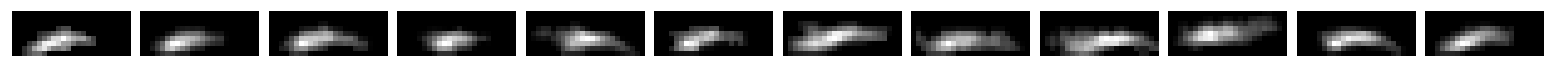

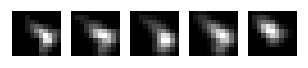

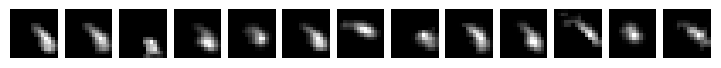

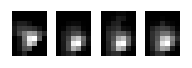

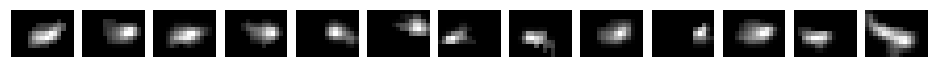

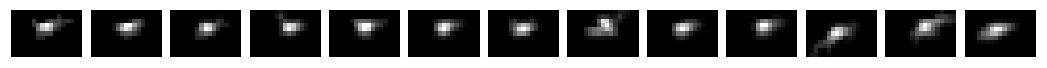

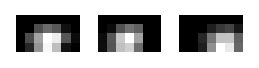

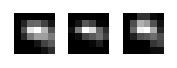

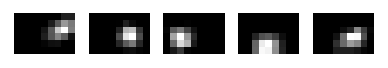

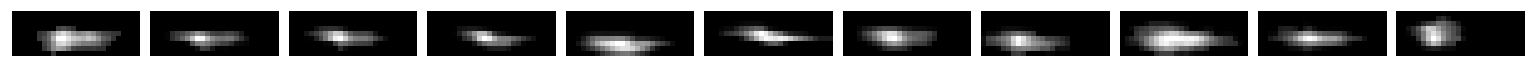

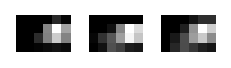

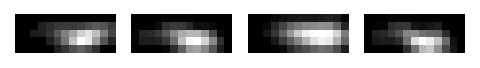

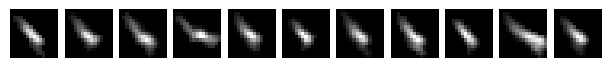

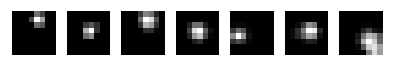

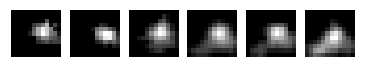

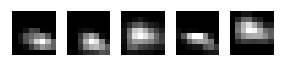

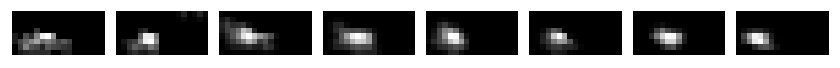

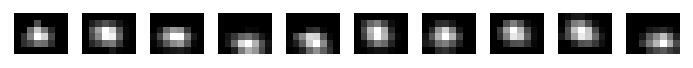

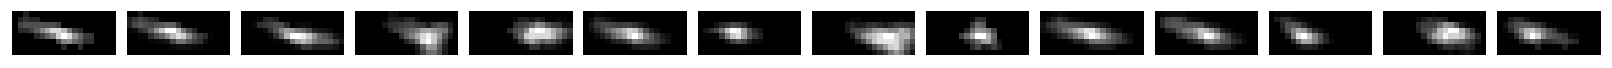

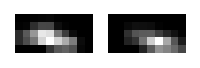

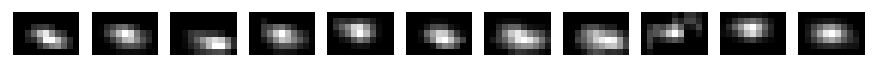

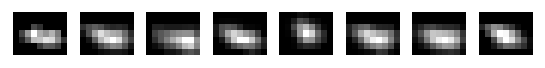

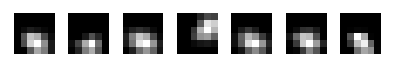

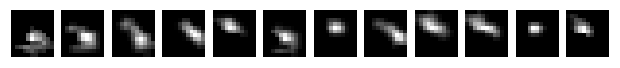

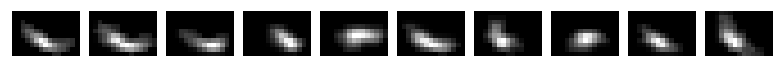

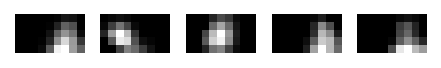

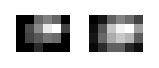

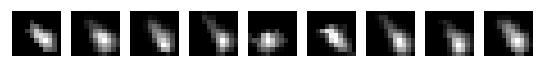

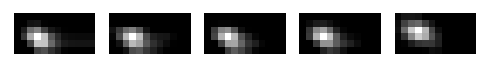

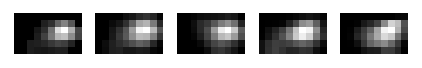

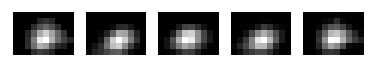

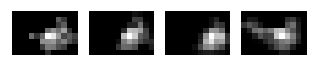

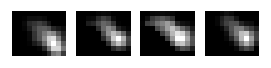

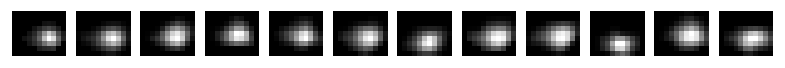

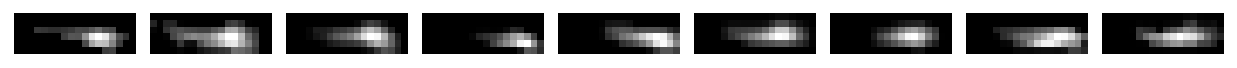

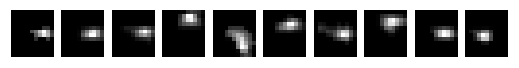

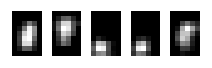

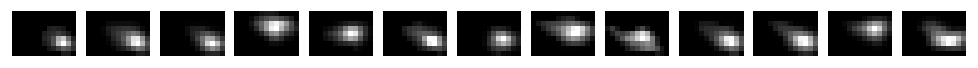

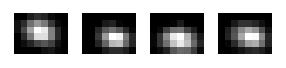

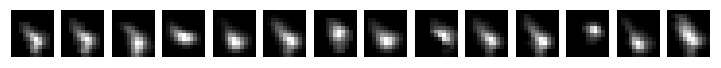

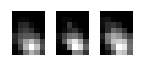

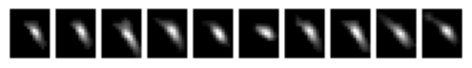

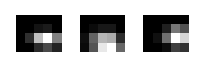

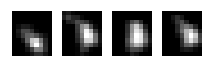

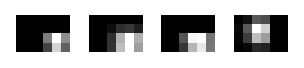

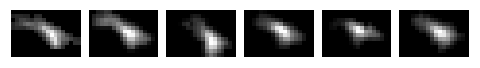

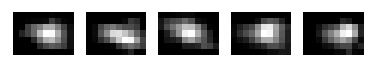

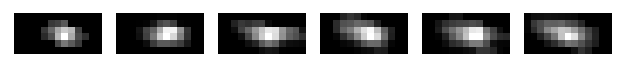

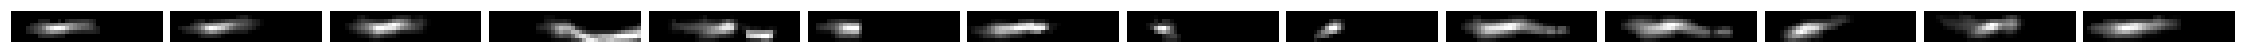

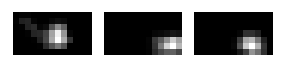

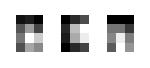

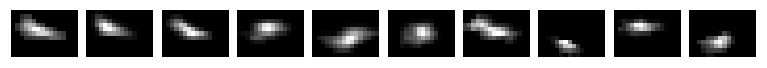

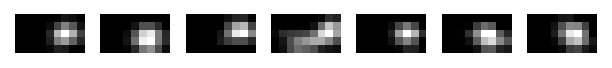

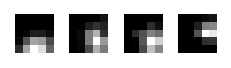

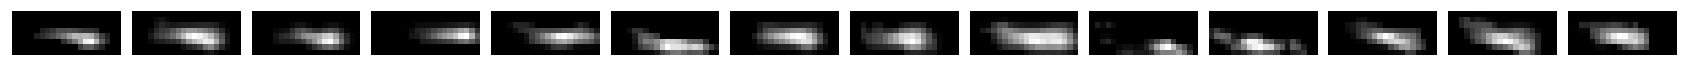

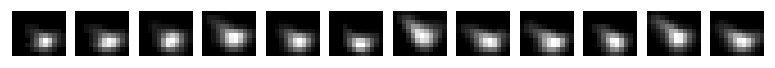

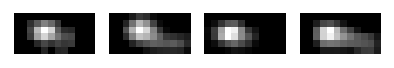

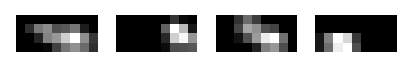

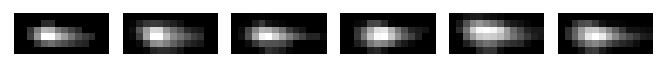

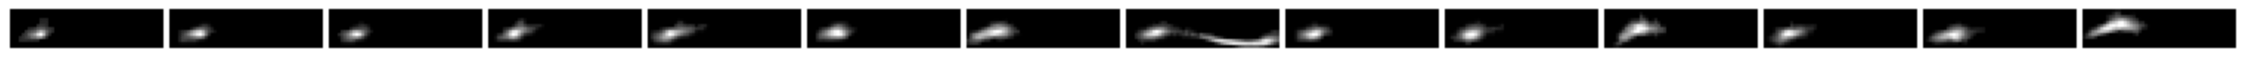

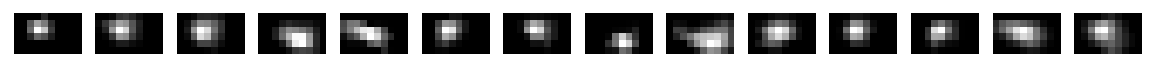

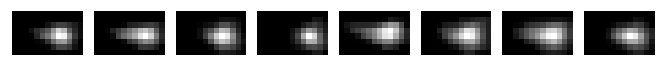

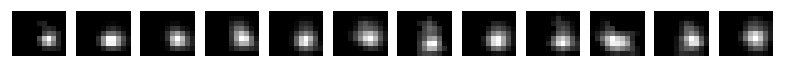

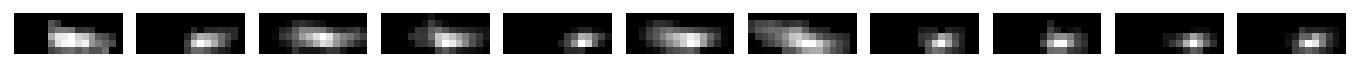

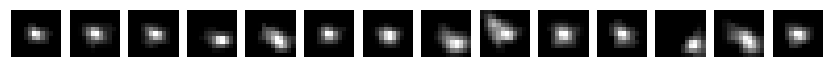

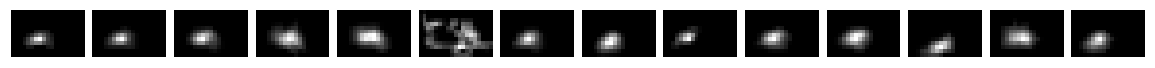

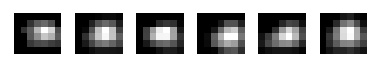

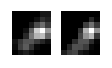

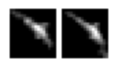

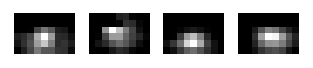

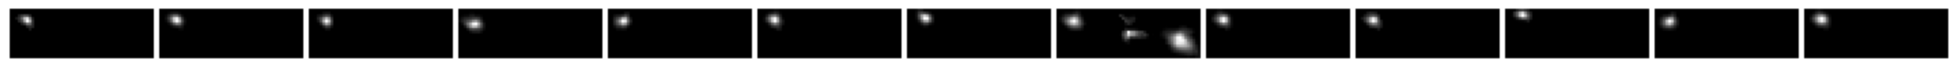

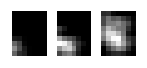

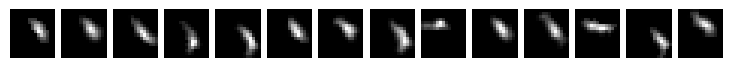

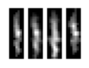

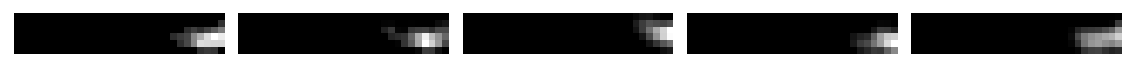

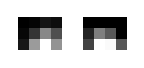

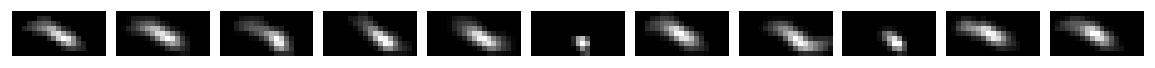

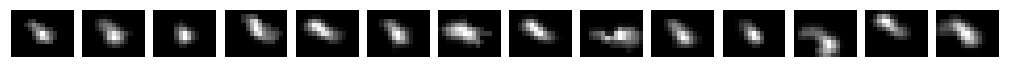

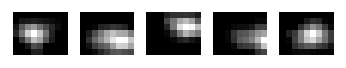

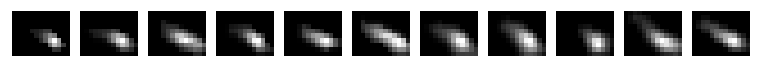

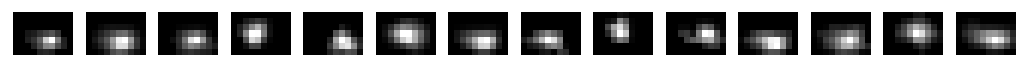

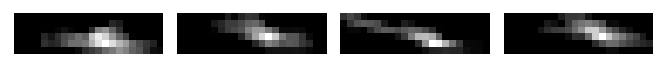

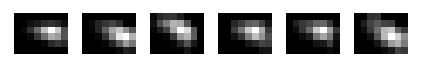

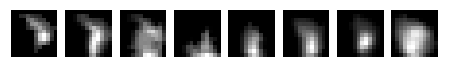

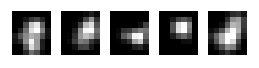

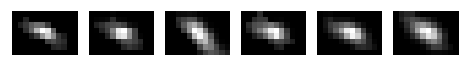

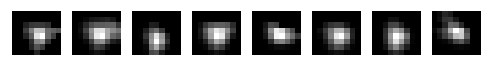

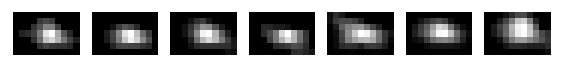

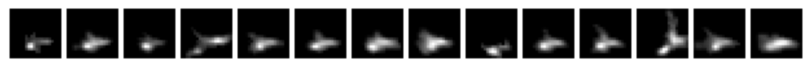

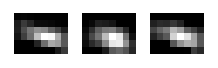

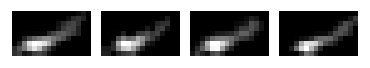

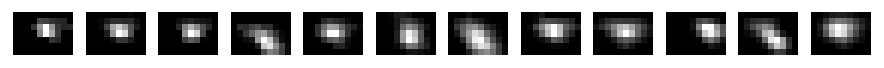

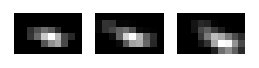

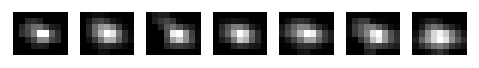

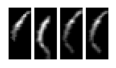

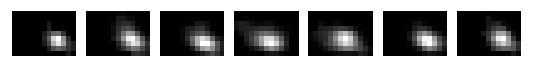

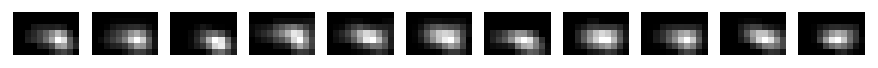

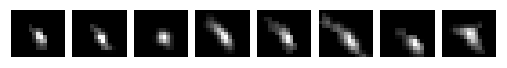

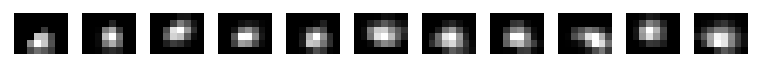

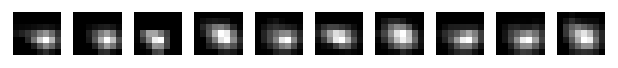

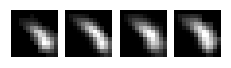

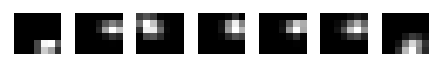

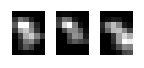

In [21]:
ucids = np.array(results['UCIDs'])
# ucids = np.concatenate(ucid_gt)
ucids_unique = np.unique(ucids[ucids>=0])

# ROI_ims = np.concatenate(data.ROI_images, axis=0)
ROI_ims_sparse = scipy.sparse.vstack(results['ROIs']['ROIs_aligned'])
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()


ucid_sfCat = []
for ucid in ucids_unique:
    idx = np.where(ucids == ucid)[0]
    ucid_sfCat.append( np.concatenate(list(visualization.crop_cluster_ims(ROI_ims_sparse[idx].toarray().reshape(len(idx), results['ROIs']['frame_height'], results['ROIs']['frame_width']))), axis=1) )
#     ucid_sfCat.append( np.concatenate(list(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width)), axis=1) )
# data.ROI_images[i_sesh][idx] for 


%matplotlib inline

for ii in range(min(len(ucid_sfCat), 50)):
    plt.figure(figsize=(40,1))
    plt.imshow(ucid_sfCat[ii], cmap='gray')
    plt.axis('off')

In [130]:
# from basic_neural_processing_modules import pickle_helpers

# test = pickle_helpers.simple_load('/media/rich/bigSSD/analysis_data/ROI_tracking/gyu_test_comparisons/test_20220825/our_sf.pickle')

# ucids = np.concatenate(test['matchings'])

# FOVs_colored = visualization.compute_colored_FOV(
#     spatialFootprints=[val.T for val in test['A']], 
#     FOV_height=test['dims'][0], 
#     FOV_width=test['dims'][1], 
#     preds=ucids, 
# )

# %matplotlib notebook

# visualization.display_toggle_image_stack(FOVs_colored)

In [50]:
import pickle
import scipy
import numpy as np


In [14]:
def compute_colored_FOV(
    spatialFootprints,
    FOV_height,
    FOV_width,
    boolSessionID,
    labels,
    confidence=None,
):
    """
    Computes a set of images of FOVs of spatial footprints, colored
     by the predicted class.

    Args:
        spatialFootprints (list of scipy.sparse.csr_matrix):
            List where each element is the sparse array of all the spatial
             footprints in that session.
        FOV_height (int):
            Height of the field of view
        FOV_width (int):
            Width of the field of view
        labels (np.ndarray):
            Label (will be a unique color) for each spatial footprint
        confidence (np.ndarray):
            Confidence for each spatial footprint
            If None, all confidence values are set to 1.
            Spatial fooprints with confidence < threshold_confidence
             have a color set to cmap(-1), which is typically black.
        threshold_confidence (float):
            Threshold for the confidence values.
    """
    if confidence is None:
        confidence = np.ones(len(labels))
    
    h, w = FOV_height, FOV_width

    rois = scipy.sparse.vstack(spatialFootprints)
    rois = rois.multiply(1.2/rois.max(1).A).power(1)

    u = np.unique(labels)

    n_c = len(u)

    colors = rand_cmap(nlabels=n_c, verbose=False)(np.linspace(0.,1.,n_c, endpoint=False))
    colors = colors / colors.max(1, keepdims=True)

    if np.isin(-1, labels):
        colors[0] = [0,0,0,0]

    labels_squeezed = squeeze_integers(labels)
    labels_squeezed -= labels_squeezed.min()

    rois_c = scipy.sparse.hstack([rois.multiply(colors[labels_squeezed, ii][:,None]) for ii in range(4)]).tocsr()
    rois_c.data = np.minimum(rois_c.data, 1)

    rois_c_bySessions = [rois_c[idx] for idx in boolSessionID.T]

    rois_c_bySessions_FOV = [r.max(0).toarray().reshape(4, h, w).transpose(1,2,0)[:,:,:3] for r in rois_c_bySessions]

    return rois_c_bySessions_FOV

In [15]:
def simple_load(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [68]:
def idx_to_oneHot(arr, n_classes=None, dtype=None):
    """
    Convert an array of class indices to matrix of
     one-hot vectors.
    RH 2021

    Args:
        arr (np.ndarray):
            1-D array of class indices.
            Values should be integers >= 0.
            Values will be used as indices in the
             output array.
        n_classes (int):
            Number of classes.
    
    Returns:
        oneHot (np.ndarray):
            2-D array of one-hot vectors.
    """
    if type(arr) is np.ndarray:
        max = np.max
        zeros = np.zeros
        arange = np.arange
        dtype = np.bool8 if dtype is None else dtype
    elif type(arr) is torch.Tensor:
        max = torch.max
        zeros = torch.zeros
        arange = torch.arange
        dtype = torch.bool if dtype is None else dtype
    assert arr.ndim == 1

    if n_classes is None:
        n_classes = max(arr)+1
    oneHot = zeros((len(arr), n_classes), dtype=dtype)
    oneHot[arange(len(arr)), arr] = True
    return oneHot

In [47]:
def squeeze_integers(intVec):
    """
    Make integers in an array consecutive numbers
     starting from 0. ie. [7,2,7,4,1] -> [3,2,3,1,0].
    Useful for removing unused class IDs from y_true
     and outputting something appropriate for softmax.
    This is v2. The old version is busted.
    RH 2021
    
    Args:
        intVec (np.ndarray):
            1-D array of integers.
    
    Returns:
        intVec_squeezed (np.ndarray):
            1-D array of integers with consecutive numbers
    """
    uniques = np.unique(intVec)
    # unique_positions = np.arange(len(uniques))
    unique_positions = np.arange(uniques.min(), uniques.max()+1)
    return unique_positions[np.array([np.where(intVec[ii]==uniques)[0] for ii in range(len(intVec))]).squeeze()]


In [48]:
def rand_cmap(
    nlabels, 
    first_color_black=False, 
    last_color_black=False,
    verbose=True,
    under=[0,0,0],
    over=[0.5,0.5,0.5],
    bad=[0.9,0.9,0.9],
    ):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.pyplot as plt
    import colorsys
    import numpy as np



    if verbose:
        print('Number of labels: ' + str(nlabels))

    randRGBcolors = np.random.rand(nlabels, 3)
    randRGBcolors = randRGBcolors / np.max(randRGBcolors, axis=1, keepdims=True)

    if first_color_black:
        randRGBcolors[0] = [0, 0, 0]

    if last_color_black:
        randRGBcolors[-1] = [0, 0, 0]

    random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        fig, ax = plt.subplots(1, 1, figsize=(6, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    random_colormap.set_bad(bad)
    random_colormap.set_over(over)
    random_colormap.set_under(under)

    return random_colormap

In [49]:
def display_toggle_image_stack(images, clim=None, **kwargs):
    import matplotlib.pyplot as plt
    from ipywidgets import interact, widgets

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    imshow_FOV = ax.imshow(
        images[0],
#         vmax=clim[1]
        **kwargs
    )

    def update(i_frame = 0):
        fig.canvas.draw_idle()
        imshow_FOV.set_data(images[i_frame])
        imshow_FOV.set_clim(clim)


    interact(update, i_frame=widgets.IntSlider(min=0, max=len(images)-1, step=1, value=0));

In [69]:
results = simple_load('/media/rich/bigSSD/analysis_data/ROI_tracking/Valerio/Proximal_Dendrites.ROICaT.results.pkl')

FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=scipy.sparse.vstack(results['ROIs']['ROIs_aligned']),
    FOV_height=results['ROIs']['frame_height'],
    FOV_width=results['ROIs']['frame_width'],
    boolSessionID=idx_to_oneHot(results['ROIs']['idx_roi_session']),
    labels=results['UCIDs'].astype(np.int64),
)

<IPython.core.display.Javascript object>


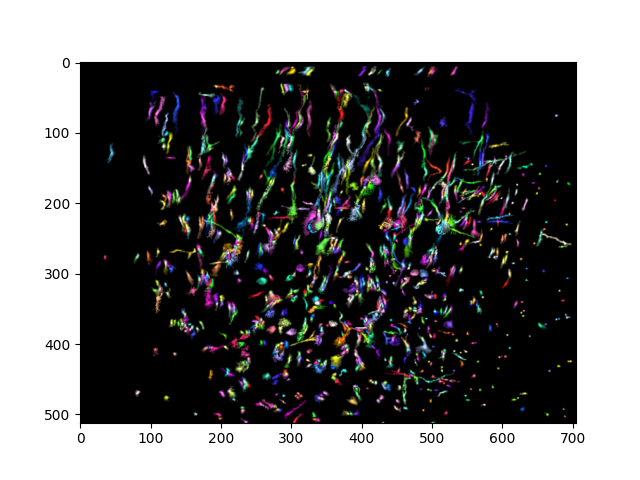

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [70]:
%matplotlib notebook
visualization.display_toggle_image_stack(FOV_clusters)

<IPython.core.display.Javascript object>


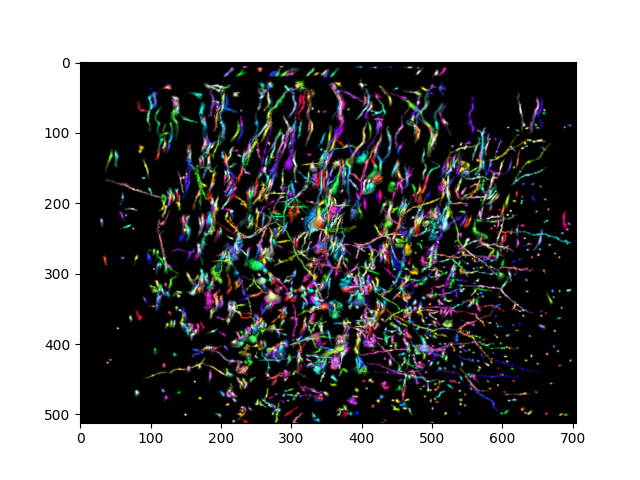

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [3]:
import pickle
import scipy
import numpy as np


def compute_colored_FOV(
    spatialFootprints,
    FOV_height,
    FOV_width,
    boolSessionID,
    labels,
    confidence=None,
):
    """
    Computes a set of images of FOVs of spatial footprints, colored
     by the predicted class.

    Args:
        spatialFootprints (list of scipy.sparse.csr_matrix):
            List where each element is the sparse array of all the spatial
             footprints in that session.
        FOV_height (int):
            Height of the field of view
        FOV_width (int):
            Width of the field of view
        labels (np.ndarray):
            Label (will be a unique color) for each spatial footprint
        confidence (np.ndarray):
            Confidence for each spatial footprint
            If None, all confidence values are set to 1.
            Spatial fooprints with confidence < threshold_confidence
             have a color set to cmap(-1), which is typically black.
        threshold_confidence (float):
            Threshold for the confidence values.
    """
    if confidence is None:
        confidence = np.ones(len(labels))
    
    h, w = FOV_height, FOV_width

    rois = scipy.sparse.vstack(spatialFootprints)
    rois = rois.multiply(1.2/rois.max(1).A).power(1)

    u = np.unique(labels)

    n_c = len(u)

    colors = rand_cmap(nlabels=n_c, verbose=False)(np.linspace(0.,1.,n_c, endpoint=False))
    colors = colors / colors.max(1, keepdims=True)

    if np.isin(-1, labels):
        colors[0] = [0,0,0,0]

    labels_squeezed = squeeze_integers(labels)
    labels_squeezed -= labels_squeezed.min()

    rois_c = scipy.sparse.hstack([rois.multiply(colors[labels_squeezed, ii][:,None]) for ii in range(4)]).tocsr()
    rois_c.data = np.minimum(rois_c.data, 1)

    rois_c_bySessions = [rois_c[idx] for idx in boolSessionID.T]

    rois_c_bySessions_FOV = [r.max(0).toarray().reshape(4, h, w).transpose(1,2,0)[:,:,:3] for r in rois_c_bySessions]

    return rois_c_bySessions_FOV

def simple_load(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def idx_to_oneHot(arr, n_classes=None, dtype=None):
    """
    Convert an array of class indices to matrix of
     one-hot vectors.
    RH 2021

    Args:
        arr (np.ndarray):
            1-D array of class indices.
            Values should be integers >= 0.
            Values will be used as indices in the
             output array.
        n_classes (int):
            Number of classes.
    
    Returns:
        oneHot (np.ndarray):
            2-D array of one-hot vectors.
    """
    if type(arr) is np.ndarray:
        max = np.max
        zeros = np.zeros
        arange = np.arange
        dtype = np.bool8 if dtype is None else dtype
    elif type(arr) is torch.Tensor:
        max = torch.max
        zeros = torch.zeros
        arange = torch.arange
        dtype = torch.bool if dtype is None else dtype
    assert arr.ndim == 1

    if n_classes is None:
        n_classes = max(arr)+1
    oneHot = zeros((len(arr), n_classes), dtype=dtype)
    oneHot[arange(len(arr)), arr] = True
    return oneHot

def squeeze_integers(intVec):
    """
    Make integers in an array consecutive numbers
     starting from 0. ie. [7,2,7,4,1] -> [3,2,3,1,0].
    Useful for removing unused class IDs from y_true
     and outputting something appropriate for softmax.
    This is v2. The old version is busted.
    RH 2021
    
    Args:
        intVec (np.ndarray):
            1-D array of integers.
    
    Returns:
        intVec_squeezed (np.ndarray):
            1-D array of integers with consecutive numbers
    """
    uniques = np.unique(intVec)
    # unique_positions = np.arange(len(uniques))
    unique_positions = np.arange(uniques.min(), uniques.max()+1)
    return unique_positions[np.array([np.where(intVec[ii]==uniques)[0] for ii in range(len(intVec))]).squeeze()]


def rand_cmap(
    nlabels, 
    first_color_black=False, 
    last_color_black=False,
    verbose=True,
    under=[0,0,0],
    over=[0.5,0.5,0.5],
    bad=[0.9,0.9,0.9],
    ):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.pyplot as plt
    import colorsys
    import numpy as np



    if verbose:
        print('Number of labels: ' + str(nlabels))

    randRGBcolors = np.random.rand(nlabels, 3)
    randRGBcolors = randRGBcolors / np.max(randRGBcolors, axis=1, keepdims=True)

    if first_color_black:
        randRGBcolors[0] = [0, 0, 0]

    if last_color_black:
        randRGBcolors[-1] = [0, 0, 0]

    random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        fig, ax = plt.subplots(1, 1, figsize=(6, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    random_colormap.set_bad(bad)
    random_colormap.set_over(over)
    random_colormap.set_under(under)

    return random_colormap

def display_toggle_image_stack(images, clim=None, **kwargs):
    import matplotlib.pyplot as plt
    from ipywidgets import interact, widgets

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    imshow_FOV = ax.imshow(
        images[0],
#         vmax=clim[1]
        **kwargs
    )

    def update(i_frame = 0):
        fig.canvas.draw_idle()
        imshow_FOV.set_data(images[i_frame])
        imshow_FOV.set_clim(clim)


    interact(update, i_frame=widgets.IntSlider(min=0, max=len(images)-1, step=1, value=0));

results = simple_load('/media/rich/bigSSD/analysis_data/ROI_tracking/Valerio/Proximal_Dendrites.ROICaT.results.pkl')

FOV_clusters = compute_colored_FOV(
    spatialFootprints=scipy.sparse.vstack(results['ROIs']['ROIs_aligned']),
    FOV_height=results['ROIs']['frame_height'],
    FOV_width=results['ROIs']['frame_width'],
    boolSessionID=idx_to_oneHot(results['ROIs']['idx_roi_session']),
    labels=results['UCIDs'].astype(np.int64),
)

%matplotlib notebook
display_toggle_image_stack(FOV_clusters)